In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def loadSimpData():
    dataMat = np.mat([
        [1.0,2.1],
        [1.5,1.6],
        [1.3,1.0],
        [1.0,1.0],
        [2.0,1.0],
    ])
    classLabels = [1.0,1.0,-1.0,-1.0,1.0]
    return dataMat,classLabels

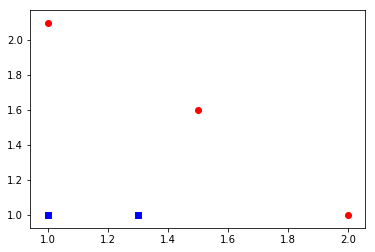

In [13]:
dataMat,classLabels = loadSimpData()
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(len(classLabels)):
    if classLabels[i] == 1.0:
        ax.scatter(dataMat[i,0],dataMat[i,1],marker = 'o',color = 'r')
    else:
        ax.scatter(dataMat[i,0],dataMat[i,1],marker = 's',color = 'b')
plt.show()

In [16]:
# 定义decision stump 单层决策树
def stumpClasify(dataMatrix,dimen,threshVal,threshIneq):
    retArray = np.ones((np.shape(dataMatrix)[0],1)) # 返回划分结果矩阵
    # 对应数值数据有两种分类方向
    # 对于标称数据有等于和不等两种情况（决策树中的情况）
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0 # 平行于坐标轴的直线为阈值，分类，小于阈值的为-1.0 ，
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0 # 大于阈值的为 -1.0 两种分类方向
    return retArray

In [37]:
def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr)
    labelMatrix = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0 # 步数，决定可能的取值情况
    bestStump = {}  # 存储最优单层树
    bestClassEst = np.mat(np.zeros((m,1))) # 存储最优单层树的分类误差
    minError = np.inf # 初始化误差为无穷大
    for i in range(n): # 对于每个维度上的特征
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax - rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1): # 对于每一个可能取值的步长，这里额外处理取值范围之外的点
            for inequal in ['lt','gt']: # 对于该取值下的两种不同分类方向
                threshVal = rangeMin + j*stepSize # 计算此时的阈值
                predictedVals = stumpClasify(dataMatrix,i,threshVal,inequal)
                errArr = np.mat(np.ones((m,1))) # 创建一个错误分类项挑选矩阵
                errArr[predictedVals == labelMatrix] = 0 # 挑选
                # 这里是评估在相同权重D情况下，最优的单层决策树的评估值，
                #也是用于更新alpha以及D的错误率
                weightedError = D.T*errArr # 计算加权错误？？？ 
#                 print("split: dim %d, thresh %.2f, thresh inequal: %s, the weighted error is %.3f"%(i,threshVal,inequal,weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClassEst = predictedVals
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClassEst

In [35]:
D = np.mat(np.ones((5,1))/5)
buildStump(dataMat,classLabels,D)

split: dim 0, thresh 0.90, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh inequal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh inequal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.50

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[ 0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [47]:
 def adaBoostTrainDS(dataArr,classLabels,numIt = 40):
        weakClassArr = [] # 分类器列表
        m = np.shape(dataArr)[0]
        D = np.mat(np.ones((m,1))/m) # 初始样本权重矩阵
        aggClassEst = np.mat(np.zeros((m,1))) # 计算最终分类结果的矩阵
        for i in range(numIt):
            bestStump,error,classEst = buildStump(dataArr,classLabels,D) # 寻找当前D情况下的最优DS decision stump
            print('D;'+str(D.T))
            
            alpha = float(0.5*np.log((1.0-error)/max(error,1e-16))) # 计算当前DS的权重并存贮
            bestStump['alpha'] = alpha
            weakClassArr.append(bestStump)
            print('class:'+str(classEst.T))
            
            expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst)  # np.mat(classLabels).T,classEst 的对应相乘，决定了D是增加还是减小
            D = np.multiply(D,np.exp(expon))
            D = D/D.sum() # 这里要使用更新权重分子后的D来计算sum，以保证D总和为1，D 本身是一个概率分布向量
            
            aggClassEst += alpha*classEst # 概率估计值，是概率值，还不是最终分类标签
            print('aggClassEst:'+str(aggClassEst.T))
            aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m,1))) 
            # np.sign(aggClassEst) 将概率估计结果转为label
            # np.sign(aggClassEst) != np.mat(classLabels).T 产生一个分类准确性 boolean 矩阵
            # 与 np.ones((m,1)) 的对应相乘 将 boolean 转换为 1 或 0
            errorRate = aggErrors.sum()/m
            print('total error: '+str(errorRate))
            if errorRate == 0.0 : break
        return weakClassArr

In [50]:
# 被分类错误的点在下次的迭代中增加了权重，
# 每一次的分类错误率由分类结果和样本权重D决定，上次分类错误的样本权重增大，寻找最优分类器过程中，会使得该样本分类正确的概率增加，
# 本次使得上次分类错误的样本分类正确，但也会使得一部分样本上次分类错误，这一次分类不正确
# 因此D的不同，导致弱分类器的分类是有侧重的，侧重量由alpha决定
# 在每一次的分类结果对于评估最终值的影响程度由分类器权重alpha决定，alpha的值由该分类器错误率决定
# 最终将所有分类结果加权求和，就是最终分类结果

# 最然弱分类器的分类效果不好，但是权重D，alpha的相互配合导致，每个分类器在这些分类错误点上各有侧重，总有一个能把结果分对
classiferArr = adaBoostTrainDS(dataMat,classLabels,9)
classiferArr

D;[[ 0.2  0.2  0.2  0.2  0.2]]
class:[[-1.  1. -1. -1.  1.]]
aggClassEst:[[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error: 0.2
D;[[ 0.5    0.125  0.125  0.125  0.125]]
class:[[ 1.  1. -1. -1. -1.]]
aggClassEst:[[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error: 0.2
D;[[ 0.28571429  0.07142857  0.07142857  0.07142857  0.5       ]]
class:[[ 1.  1.  1.  1.  1.]]
aggClassEst:[[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error: 0.0


[{'alpha': 0.6931471805599453, 'dim': 0, 'ineq': 'lt', 'thresh': 1.3},
 {'alpha': 0.9729550745276565, 'dim': 1, 'ineq': 'lt', 'thresh': 1.0},
 {'alpha': 0.8958797346140273,
  'dim': 0,
  'ineq': 'lt',
  'thresh': 0.90000000000000002}]

In [52]:
# 分类结果进行加权求和
def adaClassify(dataToClass,classiferArr):
    dataMatrix = np.mat(dataToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classiferArr)):
        classEst = stumpClasify(dataMatrix,classiferArr[i]['dim'],classiferArr[i]['thresh'],classiferArr[i]['ineq'])
        aggClassEst += classiferArr[i]['alpha']*classEst 
        print(aggClassEst)
    return np.sign(aggClassEst)    

In [53]:
adaClassify([0,0],classiferArr)

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [54]:
adaClassify([1.1,1.1],classiferArr)

[[-0.69314718]]
[[ 0.27980789]]
[[ 1.17568763]]


matrix([[ 1.]])